Aluno: Gabriel Freitas Santos
MEC 2014

0 - Desenvolvimento do Modelo AR do trabalho anterior

In [1]:
import pandas as pd
import scipy.io as sio
import numpy as np
from os import getcwd,pardir
from os.path import join ,abspath
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from statsmodels.tsa import ar_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from scipy import stats
from scipy.stats.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, RepeatedKFold,
RandomizedSearchCV)
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [3]:
fname = join(abspath(join(getcwd(), pardir))+'\\02_feature','data3SS2009.mat')
mat_contents = sio.loadmat(fname)
dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
y = mat_contents['labels'].reshape(Nc)
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar
FeatAR = []
na=30 #Model Order
for i in range(Nc):
    ARmodel2 = ar_model.AutoReg(Ch2[:,i],na).fit()
    ARmodel3 = ar_model.AutoReg(Ch3[:,i],na).fit()
    ARmodel4 = ar_model.AutoReg(Ch4[:,i],na).fit()
    ARmodel5 = ar_model.AutoReg(Ch5[:,i],na).fit()
    ARparams = np.concatenate([ARmodel2.params,ARmodel3.params,ARmodel4.params,ARmodel5.params])
    FeatAR.append(ARparams)
FeatAR=np.array(FeatAR)
FeatAR.shape # X1
ln,cols = FeatAR.shape
#Montar metodo de normalização
scaler = MinMaxScaler(feature_range=(-1,1))
dfAR = pd.concat([pd.DataFrame(scaler.fit_transform(FeatAR)),pd.DataFrame({'target':y})],axis=1) #Normalização e criação de DF para plot de X1

01 - Design of Hyperparameter search:

Testing 3 different models: softamax, SVM and KNN

In [25]:
models = []
models.append(LogisticRegression())#multi_class='multinomial'))
models.append(SVC())
models.append(KNeighborsClassifier())
models

[LogisticRegression(), SVC(), KNeighborsClassifier()]

Define parameters to be tested:

In [46]:
param_grids =[]
param_grids.append( #Softmax
    
        {
            "C":[1, 10, 20, 60, 70, 100],
            "solver" :[ 'lbfgs', 'liblinear', 'sag']  
        }
    
)
param_grids.append( #SVC
    
        {
            "C"      : stats.loguniform(1e-1,1e3),
            "kernel" : ['linear','poly','rbf','sigmoid'],
            "degree" : stats.randint(2,5),
            "gamma"  : stats.loguniform(1e-4,1e0),
            #"epsilon"  : stats.loguniform(1e-4,1e1)
        }
    
)
param_grids.append( #KNN
    
        {
            "n_neighbors" : stats.randint(2,100),
            "weights"      : ["uniform","distance"],
            "algorithm" : [ "ball_tree", "kd_tree", "brute"],
            "leaf_size" : stats.randint(1,30)            
        }
    
)

Get results for default parameters from each model

In [47]:
kfolds = 5
nkiter = 50
n_iter = 100
acc=[]
cfmx =[]
best_params =[]
for i,md in enumerate(models):
    print(f'Iteração {i+1} - {md}\n')
    #Separar Data set em conjuntos de treino e teste ()
    train_x, test_x, train_y, test_y = train_test_split(dfAR[dfAR.columns[0:-1]], dfAR.target, test_size=0.4, random_state=i)

    rkf = RepeatedKFold(n_splits=kfolds,n_repeats=nkiter,random_state=i)

    #clf = Pipeline([md])

    param_grid = param_grids[i]

    #Cria modelo
    rnd_model = RandomizedSearchCV(md,verbose=0,n_iter=n_iter,n_jobs=-1,cv=rkf,
                                    random_state=i,param_distributions=param_grid,scoring=accuracy_score)
    rnd_model.fit(train_x,train_y)
    best_params.append(rnd_model.best_params_)
    yh_teste = rnd_model.predict(test_x)
    acc.append(accuracy_score(test_y, yh_teste,normalize=True))
    cfmx.append(confusion_matrix(test_y, yh_teste))
    print(f'Resultados: Acurácia={acc[i]}\n')
   

Iteração 1 - LogisticRegression()



C:\Users\gfs\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\gfs\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\gfs\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Resultados: Acurácia=0.9970588235294118

Iteração 2 - SVC()



C:\Users\gfs\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Resultados: Acurácia=0.9970588235294118

Iteração 3 - KNeighborsClassifier()

Resultados: Acurácia=0.7411764705882353



C:\Users\gfs\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Confusion Matrix Comparing

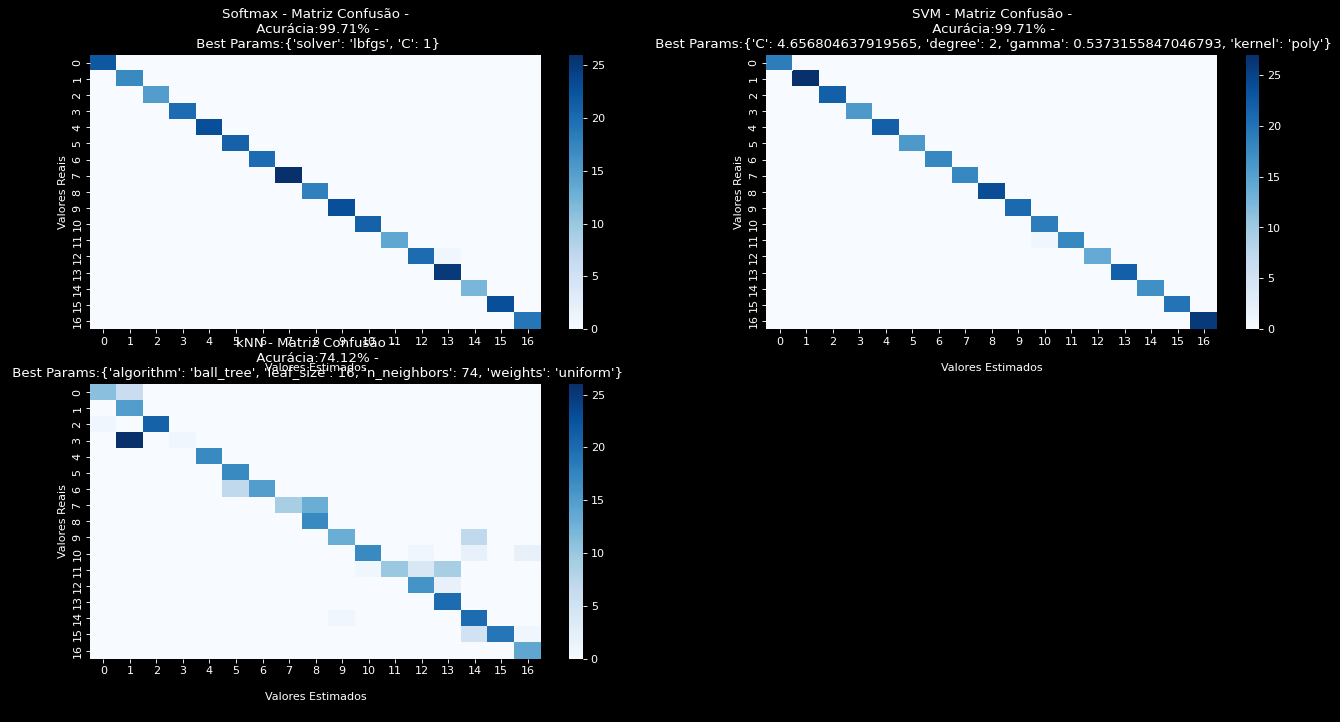

In [48]:
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(221)
ax0 = sns.heatmap(cfmx[0],  cmap='Blues')
ax0.set_title(f'Softmax - Matriz Confusão -\n Acurácia:{round(100*acc[0],2)}% -\n Best Params:{best_params[0]}')
ax0.set_xlabel('\nValores Estimados\n')
ax0.set_ylabel('Valores Reais')

plt.subplot(222)
ax1 = sns.heatmap(cfmx[1],  cmap='Blues')
ax1.set_title(f'SVM - Matriz Confusão -\n Acurácia:{round(100*acc[1],2)}% -\n Best Params:{best_params[1]}')
ax1.set_xlabel('\nValores Estimados\n')
ax1.set_ylabel('Valores Reais')

plt.subplot(223)
ax2 = sns.heatmap(cfmx[2],  cmap='Blues')
ax2.set_title(f'kNN - Matriz Confusão -\n Acurácia:{round(100*acc[2],2)}% -\n Best Params:{best_params[2]}')
ax2.set_xlabel('\nValores Estimados\n')
ax2.set_ylabel('Valores Reais')
plt.show()
